<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Fine-tuning an Action Recognition Model on HMDB51

In this notebook, we demonstrate how to get the SOTA results for the [HMDB51](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/) human action dataset using the R(2+1)D model.

## Initialization

Import all the functions we need

In [24]:
import sys
sys.path.append("../../")
import time
import os
import numpy as np
import torch
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import requests

from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.action_recognition.dataset import VideoRecord, VideoDataset
from utils_cv.action_recognition.data import Urls
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path

system_info()

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters. 

Using the paramters below, one can reproduce published results on the HMDB-51 dataset. Video-clip accuracy of close to 80%  can be obtained using as input to the DNN 32 consecutive frames (`MODEL_INPUT_SIZE`) and running 48 training epochs. Even using only 8 epochs the accuracy already reaches 75%. Inference and training speed can be reduced by a factor of 3-4 by setting `MODEL_INPUT_SIZE=8` and using higher batch size, however at a significant loss in accuracy.

In [3]:
# Number of consecutive frames used as input to the DNN. Recommended: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 8

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 8

# Number of training epochs
EPOCHS = 8

# Learning rate
LR = 0.0001

## Downloading HMDB51

Since we're trying to train our model ont he hmdb51 dataset, we'll need to download it. You find the link to download it [here](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/). Once downloaded, set `VIDEO_DIR` to the location of the videos.

In [4]:
DATA_ROOT = os.path.join(str(data_path()), "misc/hmdb51")
VIDEO_DIR = os.path.join(DATA_ROOT, "videos")

For this notebook, we'll try to reproduce the SOTA results on HMDB51 using a specific train/test split known simply as "split1". Download the split and specify where the download location.

In [5]:
def download(url: str, loc: str):
    r = requests.get(url)
    with open(loc, 'wb') as f:
        f.write(r.content)
    return loc
        
TRAIN_SPLIT = download(Urls.hmdb_train_split_1, os.path.join(DATA_ROOT, "hmdb51_train_split_1.txt"))
TEST_SPLIT = download(Urls.hmdb_test_split_1, os.path.join(DATA_ROOT, "hmdb51_test_split_1.txt"))

---

# Prepare HMDB51 using the Video Dataset

We can load the downloaded HMBD51 dataset into our `VideoDataset` class by simply passing it the location of the folder. We demonstrated how this is done in the previous [01_training_introduction.ipynb](./01_training_notebook.ipynb) notebook. 

However, because we're trying to reproduce the results in the paper, we'll have to use a specific split of the training and testing data as defined by the `TRAIN_SPLIT` and `TEST_SPLIT` files. This is refered to in the paper as "split1". Conviniently, the `VideoDataset` class can take in a __train_split_file__ and a __test_split_file__ as parameters, so we can pass it directly into the VideoDataset.

For these parameters to work, the file must come in the following format:
```
<action_type>/<video_name> <label_number>
```

Here's what the top part __hmdb51_vid_train_split_1.txt__ looks like.
```
fencing/AHF_Rapier_fencing_f_cm_np2_le_bad_2 13
situp/Timed_situps_1_minute_situp_f_nm_np1_ri_med_1 38
brush_hair/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np2_le_goo_0 0
swing_baseball/BaseballHitinSlowMotion_swing_baseball_f_nm_np1_le_bad_1 43
clap/#20_Rhythm_clap_u_nm_np1_le_goo_3 4
laugh/Skype_Laughter_by_Hungary_laugh_h_nm_np2_fr_goo_1 23
ride_horse/ChampagneRunattheParkHT_ride_horse_f_cm_np1_ri_med_1 31
swing_baseball/practicingmybaseballswing2009_swing_baseball_f_cm_np1_fr_med_5 43
...
```

Notice that the extension (".mp3", ".avi") is passed in separately.

In [6]:
data = VideoDataset(
    VIDEO_DIR,
    train_split_file=TRAIN_SPLIT,
    test_split_file=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    sample_length=MODEL_INPUT_SIZE,
    video_ext="avi",
)

Here's what the train/test split ends up looking like.

In [18]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 3570 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f581b4c34a8>     
Testing dataset: 1530 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f581b14d978>


Now that the data is loaded, we can take a quick look at some samples.

/home/jiata/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


<Figure size 432x288 with 0 Axes>

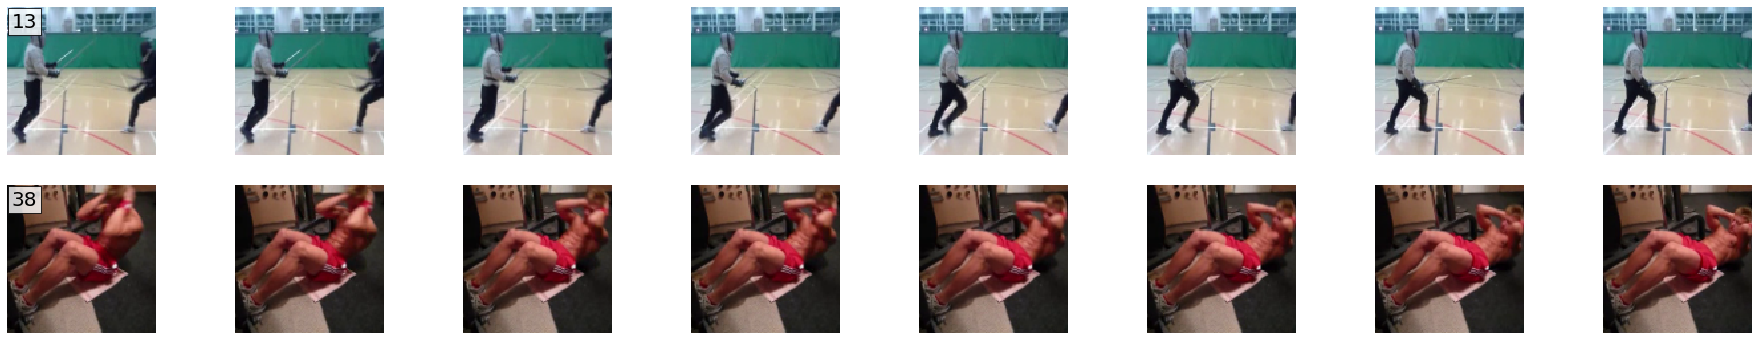

In [7]:
data.show_batch(rows=2)

Lets also take a look at the (default) parameters that we're using:

In [8]:
print(f"""\
sample_length: {data.sample_length}
sample_step: {data.sample_step}
temporal_jitter: {data.temporal_jitter}
temporal_jitter_step: {data.temporal_jitter_step}
random_shift: {data.random_shift}
""")

sample_length: 8
sample_step: 1
temporal_jitter: True
temporal_jitter_step: 2
random_shift: True



## Setup the Video Learner

In [9]:
learner = VideoLearner(data, num_classes=51)

Loading r2plus1d_34_8_ig65m model


Using cache found in /home/jiata/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [10]:
learner.model.fc

Linear(in_features=512, out_features=51, bias=True)

Params to learn:
	full network
Epoch 1 =========================================================
lr=[0.0001]
train took 199.28 sec | loss = 3.6691 | top1_acc = 18.4034  | top5_acc = 37.3669
valid took 64.12 sec | loss = 3.2957 | top1_acc = 13.4641  | top5_acc = 43.0719
Epoch 2 =========================================================
lr=[0.0001]
train took 195.28 sec | loss = 2.9421 | top1_acc = 45.8263  | top5_acc = 75.1541
valid took 67.34 sec | loss = 2.3462 | top1_acc = 45.0980  | top5_acc = 73.2026
Epoch 3 =========================================================
lr=[0.0001]
train took 197.12 sec | loss = 2.3615 | top1_acc = 55.0420  | top5_acc = 83.2493
valid took 62.30 sec | loss = 2.0551 | top1_acc = 46.0131  | top5_acc = 77.5817
Epoch 4 =========================================================
lr=[0.0001]
train took 195.69 sec | loss = 1.9644 | top1_acc = 59.7479  | top5_acc = 86.7507
valid took 62.97 sec | loss = 1.9103 | top1_acc = 50.3268  | top5_acc = 76.1438
Epoch 5 =====

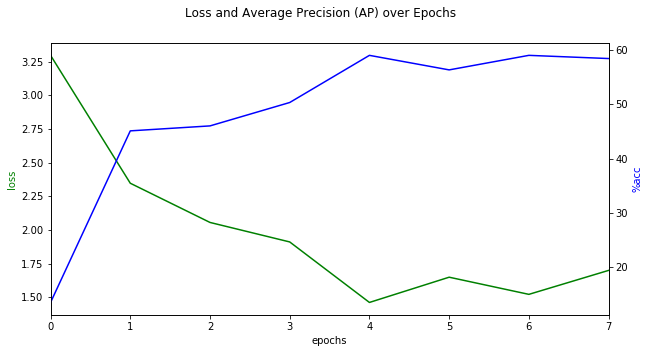

In [11]:
learner.fit(lr=LR, epochs=EPOCHS)

## Model Test

Reported accuracy from "Closer look" paper: 74.5% (clip accuracy of 66.1% on split1 based on VMZ repo)

1. sample 10 clips uniformly sampled from each test video: [10 x 3 x (8 or 32) x 112 x 112]
2. calculate clip-level accuracy: Use 10 batch and infer
3. calculate video-level accuracy by averaging them
4. average over the clips

In [13]:
ret = learner.evaluate()

1530 samples of torch.Size([3, 8, 112, 112])
Processsing 100 of 1530 samples..
Processsing 200 of 1530 samples..
Processsing 300 of 1530 samples..
Processsing 400 of 1530 samples..
Processsing 500 of 1530 samples..
Processsing 600 of 1530 samples..
Processsing 700 of 1530 samples..
Processsing 800 of 1530 samples..
Processsing 900 of 1530 samples..
Processsing 1000 of 1530 samples..
Processsing 1100 of 1530 samples..
Processsing 1200 of 1530 samples..
Processsing 1300 of 1530 samples..
Processsing 1400 of 1530 samples..
Processsing 1500 of 1530 samples..
Avg. inference time per video (1530 clips) = 92.85304201748576 ms
Video prediction accuracy = 0.5853499018966645
Clip prediction accuracy = 0.5540876389797253
